<a href="https://colab.research.google.com/github/LianaHuang99/Recommendation-System/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build a model based on the data you have scraped. Don't worry if the model is far from perfect. You can always improve later. The most important thing is your story, you can answer the following questions after you finish modeling.

1. Why this project is important? What problem are you trying to solve?

2. How do you measure the model performance (metrics)? What is the benchmark?

3. How is your model? Have achieved your goal? How to evaluate the business value of your model?

4. Any insights have you gotten from your model? Any actionable suggestions can you provide to your business partner?

5. What is the most challenging part in the project? How did you solve it? How will you futher improve your model if you get more resources and time.

Make sure that your work includes these parts:
1. **Pre-model Analysis**: process and visualize data; get insights of features and target.
2. **Problem Definition**: translate the business needs into machine learning problems; design metrics to measure model performance.
3. **Feature Engineering**: create features which might improve model performance.
4. **Modeling**: Model selection, feature elimination, validation, hyperparameter tuning.
5. **Post-model Analysis**: Model performance, feature importance, actionable suggestions to business.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


<span style = 'font-size:30px;'> **Exploratory Data Analysis** </span>

<span style = 'font-size:20px;'> 1. u.data: user-item interaction data</span>

In [2]:
data = pd.read_csv('u.data', sep = '\t', header = None)
data.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
data.columns = ['user_id', 'movie_id', 'rating','timestamp']
data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
data.shape

(100000, 4)

In [5]:
data.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


<span style = 'font-size: 20px;'>**Observation:** there is no missing values in the ratings dataframe. The scale of ratings is 1 to 5. The mean rating is 3.53 with a standard deviation of 1.13. There are 25% of ratings<= 3, 50% ratings <= 4, and 75% ratings <= 4.</span>

In [6]:
n_movies = data['movie_id'].nunique()
print('Number of movies:', n_movies)

Number of movies: 1682


In [7]:
n_users = data['user_id'].nunique()
print('Number of users:', n_users)

Number of users: 943


In [8]:
n_ratings = data['rating'].value_counts().sum()
print('Number of ratings:', n_ratings)

Number of ratings: 100000


In [9]:
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Average number of ratings per user: 106.04
Average number of ratings per movie: 59.45


<span style = 'font-size:20px;'> 2. u.item: movies metadata</span>

In [10]:
movies = pd.read_csv('u.item', sep="|", encoding='latin-1', header=None)
movies.columns = ['movie_id', 'movie_title' ,'release_date','video_release_date', 'imdb_url', 'unknown', 'Action',
                 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<span style = 'font-size: 20px;'>**Identify Duplicates Based on Movie Attributes**</span>

In [11]:
columns = movies.columns.tolist()
len(movies), len(movies.groupby(by = columns[1:]))

(1682, 1664)

In [12]:
# Find duplicates based on columns excluding movie_id
duplicates = movies[movies.duplicated(subset=columns[1:], keep = False)]
print(duplicates[['movie_id','movie_title']])


      movie_id                     movie_title
245        246              Chasing Amy (1997)
265        266       Kull the Conqueror (1997)
267        268              Chasing Amy (1997)
296        297              Ulee's Gold (1997)
302        303              Ulee's Gold (1997)
303        304            Fly Away Home (1996)
304        305           Ice Storm, The (1997)
308        309                 Deceiver (1997)
328        329       Desperate Measures (1998)
347        348       Desperate Measures (1998)
499        500            Fly Away Home (1996)
572        573           Body Snatchers (1993)
669        670           Body Snatchers (1993)
679        680       Kull the Conqueror (1997)
710        711   Substance of Fire, The (1996)
864        865           Ice Storm, The (1997)
875        876              Money Talks (1997)
877        878           That Darn Cat! (1997)
880        881              Money Talks (1997)
1002      1003           That Darn Cat! (1997)
1174      117

<span style = 'font-size: 20px;'>Map Duplicate movie_ids to a Single ID </span>

In [13]:
# Create a mapping of movie_id -> unified_id

unified_id = duplicates.groupby(['movie_title', 'release_date'])['movie_id'].transform('min')
duplicates['unified_id'] = unified_id
movie_id_mapping = duplicates.set_index('movie_id')['unified_id'].to_dict()
movie_id_mapping

{246: 246,
 266: 266,
 268: 246,
 297: 297,
 303: 297,
 304: 304,
 305: 305,
 309: 309,
 329: 329,
 348: 329,
 500: 304,
 573: 573,
 670: 573,
 680: 266,
 711: 711,
 865: 305,
 876: 876,
 878: 878,
 881: 876,
 1003: 878,
 1175: 1175,
 1234: 1234,
 1256: 1256,
 1257: 1256,
 1395: 1395,
 1429: 1429,
 1477: 1477,
 1606: 309,
 1607: 1395,
 1617: 1175,
 1625: 1477,
 1645: 1645,
 1650: 1645,
 1654: 1234,
 1658: 711,
 1680: 1429}

In [14]:
movies['movie_id'] = movies['movie_id'].map(lambda x: movie_id_mapping.get(x, x))
movies['movie_id'].nunique()

1664

In [15]:
movies.drop_duplicates(inplace = True)
len(movies)

1664

<span style = 'font-size 20px;'> **Unifiy the movie_ids** Using movie_id_mapping to unify the movie_ids for the movie with multiple movie ids in user-item interaction dataset.</span>

In [16]:
data['movie_id'] = data['movie_id'].map(lambda x: movie_id_mapping.get(x, x))
data['movie_id'].nunique()

1664

<span style = 'font-size:20px;'> 3. u.user: users' demographic information</span>

In [17]:
users = pd.read_csv('u.user', sep="|", encoding='latin-1', header=None)
users.columns = ['user_id', 'age', 'gender', 'occupation', 'zip code']
users.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [18]:
columns = users.columns.tolist()
len(users), len(users.groupby(by = columns[1:]))

(943, 936)

In [19]:
users[users.duplicated(subset=columns[1:], keep = False)].sort_values(by = ['age', 'zip code'])

,user_id,age,gender,occupation,zip code
66,67,17,M,student,60402
620,621,17,M,student,60402
197,198,21,F,student,55414
495,496,21,F,student,55414
436,437,27,F,other,20009
804,805,27,F,other,20009
427,428,28,M,student,55414
683,684,28,M,student,55414
349,350,32,M,student,97301
889,890,32,M,student,97301


<span style='font-size:20px;'> In the users demographic dataset, there are 14 users having the same demographic information but with different user IDs. Although these might be duplicated data, it is still possible that there are users with the same age, gender, occupation and living in the same zip code. So we just keep these data as it is.</span>

<span style = 'font-size:20px;'>**Handle duplicates in user-item interaction dataset.**

In movies dataset, there are 18 movies asigned with multiple movie_ids, this is fixed by asign the smallest movie_id to the movie and applied to the data dataset (user-item interaction dataset). Duplicates are found in data, the following steps are about removing or handling duplicates. </span>

In [20]:
duplicates = data[data.duplicated(keep = False)]
duplicates_sorted = duplicates.sort_values(by=['user_id','movie_id'])
print(duplicates_sorted)

       user_id  movie_id  rating  timestamp
11227        3       329       4  889237455
35195        3       329       4  889237455
2810         7       266       4  891350703
8873         7       266       4  891350703
20946       13       329       2  886952246
...        ...       ...     ...        ...
82077      819       246       4  884012614
88800      870       246       3  881000751
91877      870       246       3  881000751
85379      939       266       2  880260636
90740      939       266       2  880260636

[70 rows x 4 columns]


<span style = 'font-size:20px;'> There are 70 rows are duplicated in all the four columns, the same user rated the same movie with the same rating and at the same time. So these are purely redundant information, which should be removed.</span>

In [21]:
data_no_duplicates = data.drop_duplicates(subset=['user_id','movie_id','rating','timestamp'])
print(data_no_duplicates)

       user_id  movie_id  rating  timestamp
0          196       242       3  881250949
1          186       302       3  891717742
2           22       377       1  878887116
3          244        51       2  880606923
4          166       346       1  886397596
...        ...       ...     ...        ...
99995      880       476       3  880175444
99996      716       204       5  879795543
99997      276      1090       1  874795795
99998       13       225       2  882399156
99999       12       203       3  879959583

[99965 rows x 4 columns]


<span style = 'font-size:20px;'> There also could be rows which have different timestamps while the same for the rest three columns. These might be the same user rated the same movie at different time but with the same rating. So these are also redundant info and should be removed.</span>

In [22]:
# Check for duplicate combinations of 'user_id','movie_id' and 'rating'
duplicates_data = data[data.duplicated(subset=['user_id', 'movie_id','rating'], keep=False)]
duplicates_data_sorted = duplicates_data.sort_values(by=['user_id','movie_id'])
print(duplicates_data_sorted)

       user_id  movie_id  rating  timestamp
20470        1       246       5  874965905
34550        1       246       5  875692927
5063         2       297       4  888550871
9201         2       297       4  888550774
11227        3       329       4  889237455
...        ...       ...     ...        ...
91586      937       297       4  876762200
85379      939       266       2  880260636
90740      939       266       2  880260636
70654      942       304       5  891282457
73640      942       304       5  891282816

[522 rows x 4 columns]


<span style = 'font-size:20px;'> There are 522 rows of such redundant information.</span>

In [23]:
data_no_duplicates = data.drop_duplicates(subset=['user_id','movie_id','rating'])
print(data_no_duplicates)

       user_id  movie_id  rating  timestamp
0          196       242       3  881250949
1          186       302       3  891717742
2           22       377       1  878887116
3          244        51       2  880606923
4          166       346       1  886397596
...        ...       ...     ...        ...
99995      880       476       3  880175444
99996      716       204       5  879795543
99997      276      1090       1  874795795
99998       13       225       2  882399156
99999       12       203       3  879959583

[99739 rows x 4 columns]


<span style = 'font-size:20px;'> The same user could rate the same movie with different ratings at different time, these information should be considered but we can take the average of the rating and then drop the duplicated rows.</span>

In [24]:
data = data_no_duplicates
multi_rated = data[data.duplicated(subset=['user_id', 'movie_id'], keep=False)]
multi_rated = multi_rated.sort_values(by = ['user_id','movie_id'])
multi_rated

,user_id,movie_id,rating,timestamp
3276,13,305,4,881514811
42231,13,305,5,882141425
5901,21,573,3,874951696
42741,21,573,2,874951898
6493,32,246,4,883717521
...,...,...,...,...
83728,863,1395,4,889289491
62716,894,246,4,882404137
90596,894,246,3,879896041
68880,934,297,5,891189969


In [25]:
# Calculate the average rating for each duplicate pair
average_ratings = multi_rated.groupby(['user_id', 'movie_id'], as_index=False).agg({'rating': 'mean'})
print("Average Ratings:\n", average_ratings)

Average Ratings:
     user_id  movie_id  rating
0        13       305     4.5
1        21       573     2.5
2        32       246     4.5
3        35       266     3.5
4        50       246     3.5
5       113       246     4.5
6       159       876     1.5
7       291       573     4.5
8       325       305     2.5
9       334       297     4.5
10      341       876     4.5
11      343       297     4.5
12      344       246     3.5
13      354       297     4.5
14      354       305     3.5
15      359       246     3.5
16      360       297     3.5
17      385       304     3.5
18      405       573     2.0
19      433       246     3.5
20      451       266     1.5
21      453       246     4.5
22      457       304     4.5
23      521       246     4.5
24      532       305     2.5
25      536       304     3.5
26      560       246     4.5
27      608       305     3.5
28      613       297     4.5
29      617       573     2.5
30      643       246     4.5
31      648       878 

In [26]:
data = data.merge(
    average_ratings,
    on=['user_id', 'movie_id'],
    how='left',
    suffixes=('', '_avg')
)
data['rating'] = data['rating_avg'].combine_first(data['rating'])
data = data.drop(columns=['rating_avg'])
data = data.drop_duplicates(subset=['user_id', 'movie_id'])

print(data)


       user_id  movie_id  rating  timestamp
0          196       242     3.0  881250949
1          186       302     3.0  891717742
2           22       377     1.0  878887116
3          244        51     2.0  880606923
4          166       346     1.0  886397596
...        ...       ...     ...        ...
99734      880       476     3.0  880175444
99735      716       204     5.0  879795543
99736      276      1090     1.0  874795795
99737       13       225     2.0  882399156
99738       12       203     3.0  879959583

[99693 rows x 4 columns]


<span style = 'font-size:20px;'> After removing duplicated rows and using average rating for multi-rated rows, the cleaned dataset has 99693 rows.</span>

<span style = 'font-size: 20px;'>**What is the distribution of movie ratings?**


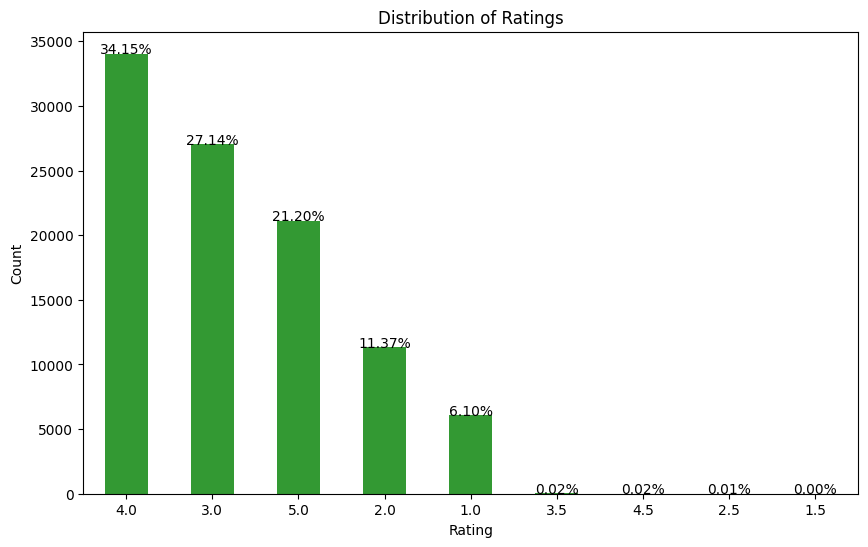

In [27]:
rating_counts = data['rating'].value_counts()
rating_frequency = (rating_counts / rating_counts.sum()) * 100
plt.figure(figsize = (10,6))
rating_counts.plot(kind='bar', color = 'green', alpha = 0.8)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.title('Distribution of Ratings')

for index,(count,percentage) in enumerate(zip(rating_counts, rating_frequency)):

    plt.text(index, count + 0.5, f'{percentage:.2f}%', ha='center', fontsize = 10)

plt.show()

In [28]:
mean_rating = data['rating'].mean()
print(f'Mean rating: {mean_rating:.2f}')

mean_rating_user = data.groupby('user_id')['rating'].mean()
print(f'Mean rating per user: {mean_rating_user.mean():.2f}')

Mean rating: 3.53
Mean rating per user: 3.59


<span style = 'font-size: 20px;'>**Observation:** The most frequent rating is 4 which accounts for 34% of the total ratings. Only 6% ratings are 1. And there are about 1/5 ratings are the max score of 5. Overall, more than 80% ratings are above 2. The mean rating of this dataset is 3.53. The average rating given by users is 3.59</span>

<span style = 'font-size:20px;'> **Which movies are most frequently rated?**

In [29]:
movie_rated_freq = data['movie_id'].value_counts().reset_index()
movie_rated_freq.columns = ['movie_id', 'n_ratings']
print(f'The top 10 rated movies are:\n {movie_rated_freq[:10]}')


The top 10 rated movies are:
    movie_id  n_ratings
0        50        583
1       258        509
2       100        508
3       181        507
4       294        485
5       286        481
6       288        478
7         1        452
8       300        431
9       121        429


<span style = 'font-size: 20px;'>**What are the lowest and highest rated movies?**

In [30]:
movies_title = movies[['movie_id','movie_title','release_date']]
movie_rating = data.groupby('movie_id')['rating'].mean().reset_index()
movie_rating = movie_rating.merge(movies_title)
movie_rating

,movie_id,rating,movie_title,release_date
0,1,3.878319,Toy Story (1995),01-Jan-1995
1,2,3.206107,GoldenEye (1995),01-Jan-1995
2,3,3.033333,Four Rooms (1995),01-Jan-1995
3,4,3.550239,Get Shorty (1995),01-Jan-1995
4,5,3.302326,Copycat (1995),01-Jan-1995
...,...,...,...,...
1659,1677,3.000000,Sweet Nothing (1995),20-Sep-1996
1660,1678,1.000000,Mat' i syn (1997),06-Feb-1998
1661,1679,3.000000,B. Monkey (1998),06-Feb-1998
1662,1681,3.000000,You So Crazy (1994),01-Jan-1994


In [31]:
min_rating = movie_rating['rating'].min()
lowest_rated_movies = movie_rating[movie_rating['rating'] == min_rating]

print(f'The lowest rated movies are:\n {lowest_rated_movies}')
print(f'The number of lowest rated movies is {len(lowest_rated_movies)}')

The lowest rated movies are:
       movie_id  rating                                        movie_title  \
311        314     1.0        3 Ninjas: High Noon At Mega Mountain (1998)   
433        437     1.0            Amityville 1992: It's About Time (1992)   
435        439     1.0                Amityville: A New Generation (1993)   
594        599     1.0  Police Story 4: Project S (Chao ji ji hua) (1993)   
777        784     1.0                               Beyond Bedlam (1993)   
...        ...     ...                                                ...   
1611      1626     1.0         Nobody Loves Me (Keiner liebt mich) (1994)   
1641      1659     1.0                    Getting Away With Murder (1996)   
1643      1661     1.0                                New Age, The (1994)   
1653      1671     1.0                          Further Gesture, A (1996)   
1660      1678     1.0                                  Mat' i syn (1997)   

     release_date  
311   01-Jan-1997  
433  

In [32]:
max_rating = movie_rating['rating'].max()
highest_rated_movies = movie_rating[movie_rating['rating'] == max_rating]

print(f'The highest rated movies are:\n {highest_rated_movies}')
print(f'The number of highest rated movies is {len(highest_rated_movies)}')

The highest rated movies are:
       movie_id  rating                                        movie_title  \
807        814     5.0                      Great Day in Harlem, A (1994)   
1112      1122     5.0                     They Made Me a Criminal (1939)   
1179      1189     5.0                                 Prefontaine (1997)   
1191      1201     5.0         Marlene Dietrich: Shadow and Light (1996)    
1282      1293     5.0                                    Star Kid (1997)   
1456      1467     5.0               Saint of Fort Washington, The (1993)   
1489      1500     5.0                          Santa with Muscles (1996)   
1525      1536     5.0                               Aiqing wansui (1994)   
1588      1599     5.0                      Someone Else's America (1995)   
1637      1653     5.0  Entertaining Angels: The Dorothy Day Story (1996)   

     release_date  
807   01-Jan-1994  
1112  01-Jan-1939  
1179  24-Jan-1997  
1191  02-Apr-1996  
1282  16-Jan-1998  
1

<span style ='font-size:20px;'>**How many ratings does each highest rated movie get?**

In [33]:
highest_rated_movies_with_counts = highest_rated_movies.merge(movie_rated_freq, on='movie_id')
highest_rated_movies_with_counts

,movie_id,rating,movie_title,release_date,n_ratings
0,814,5.0,"Great Day in Harlem, A (1994)",01-Jan-1994,1
1,1122,5.0,They Made Me a Criminal (1939),01-Jan-1939,1
2,1189,5.0,Prefontaine (1997),24-Jan-1997,3
3,1201,5.0,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,1
4,1293,5.0,Star Kid (1997),16-Jan-1998,3
5,1467,5.0,"Saint of Fort Washington, The (1993)",01-Jan-1993,2
6,1500,5.0,Santa with Muscles (1996),08-Nov-1996,2
7,1536,5.0,Aiqing wansui (1994),22-Jul-1996,1
8,1599,5.0,Someone Else's America (1995),10-May-1996,1
9,1653,5.0,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,1


<span style ='font-size:20px;'>**How many ratings does each lowest rated movie get?**

In [34]:

lowest_rated_movies_with_counts = lowest_rated_movies.merge(movie_rated_freq, on='movie_id')
lowest_rated_movies_with_counts

,movie_id,rating,movie_title,release_date,n_ratings
0,314,1.0,3 Ninjas: High Noon At Mega Mountain (1998),01-Jan-1997,5
1,437,1.0,Amityville 1992: It's About Time (1992),01-Jan-1992,5
2,439,1.0,Amityville: A New Generation (1993),01-Jan-1993,5
3,599,1.0,Police Story 4: Project S (Chao ji ji hua) (1993),16-Aug-1996,1
4,784,1.0,Beyond Bedlam (1993),01-Jan-1993,2
...,...,...,...,...,...
64,1626,1.0,Nobody Loves Me (Keiner liebt mich) (1994),09-Feb-1996,1
65,1659,1.0,Getting Away With Murder (1996),12-Apr-1996,1
66,1661,1.0,"New Age, The (1994)",01-Jan-1994,1
67,1671,1.0,"Further Gesture, A (1996)",20-Feb-1998,1


<span style ='font-size:20px;'>**Observations:** The highest and lowest rated movies based on the average ratings are not fair. Because some of them are only rated once or very few times. We should take the number of ratings into account. Use Bayesian Average to reduces bias, balances quality and popularity, and ensures fairness in rankings.

In [35]:
#calculate the average number of ratings for a given movie

movie_stats = data.groupby('movie_id')['rating'].agg(['count', 'mean'])
movie_stats

,count,mean
movie_id,,
1,452,3.878319
2,131,3.206107
3,90,3.033333
4,209,3.550239
5,86,3.302326
...,...,...
1677,1,3.000000
1678,1,1.000000
1679,1,3.000000


In [36]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 59.91
Average rating for a given movie: 3.08


In [37]:
bayesian_avg_ratings = data.groupby('movie_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movie_id', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movie_id')

In [38]:
movie_rank = movie_stats.sort_values('bayesian_avg', ascending=False)
movie_rank = movie_rank.merge(movies_title, on = 'movie_id')
print('The top 10 rated movies')
movie_rank.head(10)

The top 10 rated movies


,movie_id,count,mean,bayesian_avg,movie_title,release_date
0,50,583,4.358491,4.239,Star Wars (1977),01-Jan-1977
1,318,298,4.466443,4.234,Schindler's List (1993),01-Jan-1993
2,64,283,4.445230,4.206,"Shawshank Redemption, The (1994)",01-Jan-1994
3,483,243,4.456790,4.184,Casablanca (1942),01-Jan-1942
4,12,267,4.385768,4.146,"Usual Suspects, The (1995)",14-Aug-1995
5,127,413,4.283293,4.130,"Godfather, The (1972)",01-Jan-1972
6,98,390,4.289744,4.128,"Silence of the Lambs, The (1991)",01-Jan-1991
7,174,420,4.252381,4.106,Raiders of the Lost Ark (1981),01-Jan-1981
8,603,209,4.387560,4.096,Rear Window (1954),01-Jan-1954
9,313,350,4.245714,4.075,Titanic (1997),01-Jan-1997


In [39]:
print('The lowest rated movies')
movie_rank.tail(10)

The lowest rated movies


,movie_id,count,mean,bayesian_avg,movie_title,release_date
1654,424,19,1.315789,2.653,Children of the Corn: The Gathering (1996),01-Jan-1996
1655,243,132,2.439394,2.638,Jungle2Jungle (1997),07-Mar-1997
1656,120,67,2.238806,2.635,Striptease (1996),28-Jun-1996
1657,743,39,1.948718,2.632,"Crow: City of Angels, The (1996)",30-Aug-1996
1658,931,57,2.157895,2.629,"Island of Dr. Moreau, The (1996)",23-Aug-1996
1659,988,86,2.313953,2.627,"Beautician and the Beast, The (1997)",07-Feb-1997
1660,890,43,1.953488,2.608,Mortal Kombat: Annihilation (1997),01-Jan-1997
1661,122,106,2.339623,2.606,"Cable Guy, The (1996)",14-Jun-1996
1662,687,69,2.188406,2.601,McHale's Navy (1997),18-Apr-1997
1663,688,44,1.840909,2.554,Leave It to Beaver (1997),22-Aug-1997


In [40]:
print('The Bayesian average of the lowest rated movie based on the raw average rating')
movie_rank[movie_rank['movie_id'] == 314]

The Bayesian average of the lowest rated movie based on the raw average rating


,movie_id,count,mean,bayesian_avg,movie_title,release_date
1518,314,5,1.0,2.917,3 Ninjas: High Noon At Mega Mountain (1998),01-Jan-1997


In [41]:
print('The Bayesian average of the highest rated movie based on the raw average rating')
movie_rank[movie_rank['movie_id'] == 814]

The Bayesian average of the highest rated movie based on the raw average rating


,movie_id,count,mean,bayesian_avg,movie_title,release_date
752,814,1,5.0,3.109,"Great Day in Harlem, A (1994)",01-Jan-1994


<span style = 'font-size: 20px;'>**Data Pre-processing**

<span style = 'font-size: 20px;'> **The user-item matrix contains significant amount of missing values.**

In [42]:
# Transpose matrix to have users as rows and movies as columns, ratings as the value
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix_np = user_item_matrix.values
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
user_ratings_count = user_item_matrix.notna().sum(axis=1)  # Non-NaN values per user
movie_ratings_count = user_item_matrix.notna().sum(axis=0)  # Non-NaN values per movie

# Find the least number of ratings
least_movies_rated_by_user = user_ratings_count.min()
least_ratings_for_movie = movie_ratings_count.min()

print(f"Least number of movies a user rated: {least_movies_rated_by_user}")
print(f"Least number of ratings a movie received: {least_ratings_for_movie}")

Least number of movies a user rated: 19
Least number of ratings a movie received: 1


<span style = 'font-size: 20px;'> **Use Sparse Matrix for the user-item matrix**

In [44]:
from scipy.sparse import csr_matrix

def create_X(df):

    M = data['user_id'].nunique()
    N = data['movie_id'].nunique()

    user_mapper = dict(zip(np.unique(data["user_id"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(data["movie_id"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(data["user_id"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(data["movie_id"])))

    user_index = [user_mapper[i] for i in data['user_id']]
    item_index = [movie_mapper[i] for i in data['movie_id']]

    X = csr_matrix((data["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(data)

In [45]:
X.shape

(943, 1664)

In [46]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = 1-n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 93.65%


In [47]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

943

In [48]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 736 movies.
Least active user rated 19 movies.


In [49]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

1664

In [50]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 583 ratings.
Least rated movie has 1 ratings.


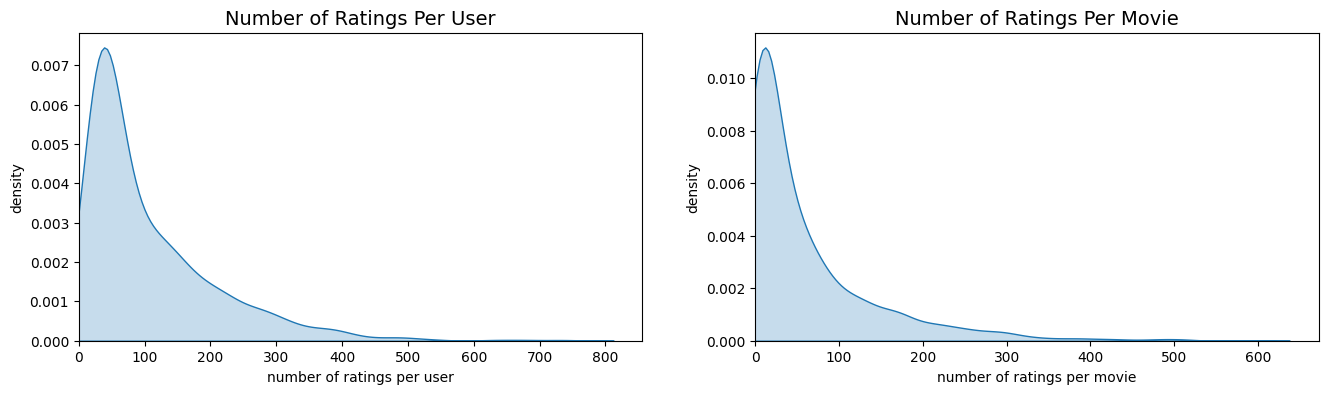

In [51]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

<span style = 'font-size: 30px;'> **Item-Based Collaborative Filtering with K Nearest Neighbours**

<span style ='font-size: 20px;'> Build Item-Item similarity matrix</span>

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix



In [62]:

#Step 1: convert csr_matrix to coo_matrix for easier splitting
item_user_matrix = X.T
item_user_coo = item_user_matrix.tocoo()
movies, users, ratings = item_user_coo.row, item_user_coo.col, item_user_coo.data

# Step 2: Split into train and test
np.random.seed(42)  # For reproducibility
indices = np.arange(len(ratings))
np.random.shuffle(indices)

# Initialize train and test indices
train_indices = []
test_indices = []

# Ensure every movie has at least one rating in the train set
for movie_id in np.unique(movies):
    movie_ratings = np.where(movies == movie_id)[0]
    if len(movie_ratings) > 2:
        train_indices.extend(movie_ratings[:-2])  # Keep all but one in train
        test_indices.append(movie_ratings[-2])   # Keep one in test
    else:
        train_indices.extend(movie_ratings)  # Keep the single interaction in train
# Ensure every user has at least one rating in the train set
for user_id in np.unique(users):
    user_ratings = np.where(users == user_id)[0]
    train_indices.extend(user_ratings[:-1])  # Keep all but one interaction in train
    test_indices.append(user_ratings[-1])   # Keep one interaction in test

# Remove duplicates
train_indices = np.unique(train_indices)
test_indices = np.setdiff1d(np.arange(len(ratings)), train_indices)

# Create train and test matrices
train = coo_matrix(
    (ratings[train_indices], (movies[train_indices], users[train_indices])),
    shape=item_user_coo.shape
)

test = coo_matrix(
    (ratings[test_indices], (movies[test_indices], users[test_indices])),
    shape=item_user_coo.shape
)

In [63]:
print("Movies in Train:", len(np.unique(train.row)))
print("Movies in Test:", len(np.unique(test.row)))
print("Users in Train:", len(np.unique(train.col)))
print("Users in Test:", len(np.unique(test.col)))


Movies in Train: 1664
Movies in Test: 118
Users in Train: 943
Users in Test: 136


In [80]:
class ItemCF:
  def __init__(self):
    self.item_similarity = None
    self.train = None

  def fit(self, train):

    self.item_similarity = cosine_similarity(train)
    self.train = train.tocsr()

  def predict(self, user_id, top_k=10):

      if self.item_similarity is None or self.train is None:
          raise ValueError("Model has not been fitted yet. Call `fit` before `predict`.")

      # Get user interaction vector
      user_interactions = self.train[:, user_id].toarray().flatten()

      predicted_ratings = np.zeros(self.train.shape[0])

      # Iterate over all items (movies)
      for movie in range(self.train.shape[0]):
          # Skip movies the user has already rated
          if user_interactions[movie] > 0:
              continue

          # Get the similarity scores for the current movie
          similarity_scores = self.item_similarity[movie]

          # Get indices of top-k similar movies that the user has rated
          rated_indices = np.where(user_interactions > 0)[0]
          top_k_indices = rated_indices[np.argsort(similarity_scores[rated_indices])[-top_k:]]

          # Compute the predicted rating for the current movie
          numerator = np.sum(similarity_scores[top_k_indices] * user_interactions[top_k_indices])
          denominator = np.sum(np.abs(similarity_scores[top_k_indices]))

          predicted_ratings[movie] = numerator / denominator if denominator != 0 else 0

      return predicted_ratings

  def recommend(self, user_id, top_n=10, exclude_rated=True):

      predictions = self.predict(user_id)

      # Exclude items already rated by the user
      if exclude_rated:
          user_interactions = self.train[:,user_id].toarray().flatten()
          predictions[user_interactions > 0] = -np.inf  # Set ratings for already rated items to -inf

      # Get indices of top N items
      recommended_items = np.argsort(predictions)[-top_n:][::-1]

      return recommended_items



In [71]:
# True ratings from the test matrix
test_rows = test.row
test_cols = test.col
true_ratings = test.data  # Actual ratings in the test matrix


In [81]:
item_cf = ItemCF()
item_cf.fit(train)
predicted_ratings = []

# Iterate through each (movie, user) pair in the test set
for movie, user in zip(test_rows, test_cols):
    # Predict all ratings for the user
    user_predictions = item_cf.predict(user_id=user)

    # Get the predicted rating for the specific movie
    predicted_ratings.append(user_predictions[movie])


In [82]:
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
print(f"RMSE: {rmse}")

RMSE: 1.0678442484204698


<span style = 'font-size:20px;'> Using Movie MetaData to Similarity Scores</span>

In [ ]:
movies.columns

In [ ]:
genres = list(movies.columns)
genres = genres[:1] + genres[6:]
genres_matrix = movies[genres].set_index('movie_id')

In [ ]:
genres_weight = 1
genres_array = genres_matrix.to_numpy()
genres_scaled = genres_array * 4 + 1
genres_sparse = csr_matrix(genres_weight * genres_scaled)

<span style='font-size:20px;'> Build movie_user matrix (user_item matrix transpose) </span>

In [ ]:
from scipy.sparse import hstack

hybrid_matrix_sparse = hstack([X.T, genres_sparse])

In [ ]:
from sklearn.neighbors import NearestNeighbors
def build_movie_similarity_mapping_optimized(X, movie_inv_mapper, k, metric='cosine'):
    #X is the hybrid_matrix_sparse, with movie_id as the rows, and user_id and genres as the columns
    # Fit NearestNeighbors model
    knn = NearestNeighbors(n_neighbors=k + 1, metric=metric, algorithm='brute')
    knn.fit(X)

    # Find neighbors and distances for all movies
    distances, indices = knn.kneighbors(X)

    # Build similarity mapping
    movie_similarity_mapping = {}
    for movie_idx in range(X.shape[0]): #X.shape[0] is the number of unique movies
        movie_id = movie_inv_mapper[movie_idx]
        similar_movies = []

        for neighbor_idx, distance in zip(indices[movie_idx, 1:], distances[movie_idx, 1:]):  # Skip itself
            similar_movie_id = movie_inv_mapper[neighbor_idx]
            similarity_score = 1 - distance  # Convert distance to similarity
            similar_movies.append((similar_movie_id, similarity_score))

        movie_similarity_mapping[movie_id] = similar_movies

    return movie_similarity_mapping


In [ ]:
k=20
movie_similarity_mapping = build_movie_similarity_mapping_optimized(hybrid_matrix_sparse, movie_inv_mapper, k, metric='cosine')

In [ ]:
formatted_mapping = [(movie_id, f"{similarity:.3f}") for movie_id, similarity in movie_similarity_mapping[2]]
print(formatted_mapping)

In [ ]:
movie_similarity_mapping_X = build_movie_similarity_mapping_optimized(X.T, movie_inv_mapper, k, metric='cosine')

In [ ]:
formatted_mapping = [(movie_id, f"{similarity:.3f}") for movie_id, similarity in movie_similarity_mapping_X[2]]
print(formatted_mapping)

In [ ]:
def recommend_movies_for_user(user_id, X, movie_similarity_mapping, movie_inv_mapper, movie_title, k, n):
    """
    Recommends movies for a user based on CSR matrix and movie similarity mapping.

    Args:
        user_id (int): The ID of the user to recommend movies for.
        X (csr_matrix): User-item matrix (CSR format).
        movie_similarity_mapping (dict): Precomputed mapping of movie_id to a list of
                                         (similar_movie_id, similarity_score) tuples.
        movie_inv_mapper (dict): Mapping of column indices back to movie IDs.
        k (int): Number of similar movies to consider for each rated movie.
        n (int): Number of recommendations to return.

    Returns:
        list: A list of (movie_id, predicted_rating) tuples for the top-n recommendations.
    """
    # Get the user's ratings as a sparse row
    user_ratings = X[user_id]

    # Extract rated movies and their ratings
    rated_movies = user_ratings.nonzero()[1]  # Movie indices
    ratings = user_ratings.data  # Corresponding ratings

    predicted_ratings = {}
    similarity_sums = {}

    # Iterate through each movie the user has rated
    for idx, movie_idx in enumerate(rated_movies):
        movie_id = movie_inv_mapper[movie_idx]
        rating = ratings[idx]

        # Get top-k similar movies for this movie
        similar_movies = movie_similarity_mapping.get(movie_id, [])[:k]

        for similar_movie_id, similarity_score in similar_movies:
            similar_movie_idx = {v: k for k, v in movie_inv_mapper.items()}.get(similar_movie_id)
            if similar_movie_idx in rated_movies:
                continue  # Skip movies the user has already rated

            # Predict rating
            weighted_rating = rating * similarity_score
            if similar_movie_id not in predicted_ratings:
                predicted_ratings[similar_movie_id] = ['',0]
                similarity_sums[similar_movie_id] = 0

            predicted_ratings[similar_movie_id][0] = movie_title.loc[similar_movie_id]['movie_title']
            predicted_ratings[similar_movie_id][1] += weighted_rating
            similarity_sums[similar_movie_id] += similarity_score

    # Normalize predicted ratings
    for movie_id in predicted_ratings:
        if similarity_sums[movie_id] > 0:
            predicted_ratings[movie_id][1] /= similarity_sums[movie_id]
            predicted_ratings[movie_id][1] = f"{predicted_ratings[movie_id][1]:.2f}"

    # Sort and return the top-n recommendations
    recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1][1], reverse=True)[:n]
    return recommendations


<span style = 'font-size:20px;'>**Split the dataset to train and test**

<span style = 'font-size:15px;'>**Split user-item matrix to train and test**

In [ ]:
train_matrix.shape

<span style='font-size:20px;'> **Random Movie Recommender** </span>

In [ ]:
class RandomRecommender:
    """
    A random recommender for benchmarking recommendation systems.
    """
    def __init__(self, strategy='uniform', random_state=None):

        self.strategy = strategy
        self.random_state = random_state
        self.min_rating = None
        self.max_rating = None
        self.observed_ratings = None

    def fit(self, train_matrix):
        np.random.seed(self.random_state)
        if self.strategy == 'uniform':
            self.min_rating = train_matrix.data.min()
            self.max_rating = train_matrix.data.max()
        elif self.strategy == 'empirical':
            self.observed_ratings = train_matrix.data
        else:
            raise ValueError("Invalid strategy! Choose 'uniform' or 'empirical'.")

    def transform(self, test_matrix):

        if self.strategy == 'uniform':
            return np.random.uniform(self.min_rating, self.max_rating, size=len(test_matrix.data))
        elif self.strategy == 'empirical':
            return np.random.choice(self.observed_ratings, size=len(test_matrix.data), replace=True)

    def fit_transform(self, train_matrix, test_matrix):
        self.fit(train_matrix)
        return self.transform(test_matrix)


In [ ]:
# Initialize random recommender
recommender = RandomRecommender(strategy='uniform', random_state=42)

# Fit and predict
predicted_ratings = recommender.fit_transform(train_matrix, test_matrix)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_matrix.data, predicted_ratings))
print(f"Random Predictions: {predicted_ratings}")
print(f"RMSE: {rmse}")


In [ ]:
# Initialize random recommender
recommender = RandomRecommender(strategy='empirical', random_state=42)

# Fit and predict
predicted_ratings = recommender.fit_transform(train_matrix, test_matrix)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_matrix.data, predicted_ratings))
print(f"Random Predictions: {predicted_ratings}")
print(f"RMSE: {rmse}")


<span style='font-size:20px;'> **KNN Movie Recommender** </span>

In [ ]:
movies_title.set_index('movie_id', inplace=True)


In [ ]:
class MovieRecommender:
    def __init__(self, k=10):
        self.k = k
        self.movie_similarity_mapping = None
        self.train_matrix = None

    def fit(self, train_matrix):
        self.movie_similarity_mapping = self.build_similarity_fn(train_matrix, self.k)
        self.train_matrix = train_matrix

    def precompute_recommendations(self, k):
        self.recommendations_cache = {}
        for user_id in range(self.train_matrix.shape[1]):
            # Convert recommendations to a dictionary for faster lookup
            recommendations = self.recommend_fn(user_id, k)
            self.recommendations_cache[user_id] = {movie: rating for movie, rating in recommendations}


    def predict(self, test_matrix, k=3):
        predicted_ratings = []
        actual_ratings = []

        for movie_id, user_id, actual_rating in zip(test_matrix.row, test_matrix.col, test_matrix.data):
            # Retrieve precomputed recommendations as a dictionary
            recommendations = self.recommendations_cache.get(user_id, {})

            # Get the predicted rating directly from the dictionary
            predicted_rating = recommendations.get(movie_id, None)

            if predicted_rating is not None:
                predicted_ratings.append(predicted_rating[1])
                actual_ratings.append(actual_rating)

        return predicted_ratings, actual_ratings


    def evaluate(self, predicted_ratings, actual_ratings):
        mse = mean_squared_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mse)
        return rmse

    def recommend(self, user_id, k = 10):

        if self.movie_similarity_mapping is None:
            raise ValueError("The model has not been trained. Call `fit` before recommending movies.")


        recommendations = self.recommend_fn(user_id, k)
        return recommendations


    def build_similarity_fn(self, train_matrix, k=10):
        # Compute cosine similarity between movies

        knn = NearestNeighbors(n_neighbors=k + 1, metric='cosine', algorithm='brute')
        knn.fit(train_matrix)

        # Find neighbors and distances for all movies
        distances, indices = knn.kneighbors(train_matrix)

        movie_similarity_mapping = {}
        for movie_idx in range(train_matrix.shape[0]):
            movie_id = movie_inv_mapper[movie_idx]
            similar_movies = []

            for neighbor_idx, distance in zip(indices[movie_idx, 1:], distances[movie_idx, 1:]):  # Skip itself
                similar_movie_id = movie_inv_mapper[neighbor_idx]
                similarity_score = 1 - distance  # Convert distance to similarity
                similar_movies.append((similar_movie_id, similarity_score))

            movie_similarity_mapping[movie_id] = similar_movies

        return movie_similarity_mapping

    def recommend_fn(self, user_id, k):

        user_ratings = self.train_matrix[:,user_id] #extract the user's ratings which is the No. user_idth column
        # user_ratings is a csr column vector with a format as [(movie_id, user_id) rating]
        # Extract rated movies and their ratings
        rated_movies = user_ratings.nonzero()[0]  # Movie indices. user_ratings.nonzero() returns a tuple of arrays indicating the indices where the values in the sparse matrix are non-zero
        ratings = user_ratings.data  # Corresponding ratings

        predicted_ratings = {}
        similarity_sums = {}

        # Iterate through each movie the user has rated
        for idx, movie_idx in enumerate(rated_movies):
            movie_id = movie_inv_mapper[movie_idx]
            rating = ratings[idx]

            # Get top-k similar movies for this movie
            similar_movies = self.movie_similarity_mapping.get(movie_id, [])[:k]

            for similar_movie_id, similarity_score in similar_movies:
                similar_movie_idx = {v: k for k, v in movie_inv_mapper.items()}.get(similar_movie_id)
                if similar_movie_idx in rated_movies:
                    continue  # Skip movies the user has already rated

                # Predict rating
                weighted_rating = rating * similarity_score
                if similar_movie_id not in predicted_ratings:
                    predicted_ratings[similar_movie_id] = ['',0]
                    similarity_sums[similar_movie_id] = 0

                predicted_ratings[similar_movie_id][0] = movies_title.loc[similar_movie_id]['movie_title']
                predicted_ratings[similar_movie_id][1] += weighted_rating
                similarity_sums[similar_movie_id] += similarity_score

        # Normalize predicted ratings
        for movie_id in predicted_ratings:
            if similarity_sums[movie_id] > 0:
                predicted_ratings[movie_id][1] /= similarity_sums[movie_id]
        # Sort and return the top-n recommendations
        recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1][1], reverse=True)[:k]
        return recommendations

In [ ]:
mr = MovieRecommender()
mr.fit(train_matrix)


In [ ]:
mr.precompute_recommendations(5)

In [ ]:
predicted_ratings, actual_ratings = mr.predict(test_matrix,5)

In [ ]:
rmse = mr.evaluate(predicted_ratings, actual_ratings)
print(f"RMSE_test: {rmse}")

In [ ]:
predicted_ratings, actual_ratings = mr.predict(train_matrix.tocoo(),5)

In [ ]:
rmse = mr.evaluate(predicted_ratings, actual_ratings)
print(f"RMSE_train: {rmse}")

In [ ]:
mr.recommend(1, 10)

<span style = 'font-size:15px;'>**SVD**

In [ ]:
!pip install scikit-surprise


In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load dataset
df = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], Reader(rating_scale=(1, 5)))

# Train-test split
trainset, testset = train_test_split(df, test_size=0.2)

# Train SVD model
model = SVD()
model.fit(trainset)

# Evaluate model
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Get recommendations for a user
user_id = 1
top_n = 10
user_predictions = [pred for pred in predictions if pred.uid == user_id]
recommended_movies = sorted(user_predictions, key=lambda x: x.est, reverse=True)[:top_n]

for pred in recommended_movies:
    print(f"Movie {pred.iid}, Predicted Rating: {pred.est:.2f}")


In [ ]:
import pickle
with open('recommendation_model.pkl', 'wb') as f:
    pickle.dump(model, f)
